# &#x1F4D1; &nbsp; $\mathfrak {\color{#00A0A0} { P2: \ Finding \ Donors \ for \ CharityML }}$

## $\mathfrak {\color{#00A0A0} {1. \ References}}$
#### Data

The dataset for this project originates from the UCI Machine Learning Repository. It was donated by Ron Kohavi and Barry Becker, after being published in the article "Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid" https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf. The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

#### Resources
pandas.get_dummies(): http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies

sklearn.preprocessing.MinMaxScaler: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
        
seaborn: http://seaborn.pydata.org/index.html

## $\mathfrak {\color{#00A0A0} {2. \ Project \ Overview}}$
In this project, we will apply supervised learning techniques and an analytical mind on data collected for the U.S. census to help CharityML (a fictitious charity organization) identify people most likely to donate to their cause.

- We will first explore the data to learn how the census data is recorded.
- Next, we will apply a series of transformations and preprocessing techniques to manipulate the data into a workable format.
- Then it needs to evaluate several supervised learners on the data and consider which is best suited for the solution.
- Afterward, we will optimize the selected model and present it as the solution to CharityML.
- Finally, we will explore the chosen model and its predictions under the hood, to see just how well it's performing when considering the data it's given.

This project is designed to get the learners acquainted with the many supervised learning algorithms available in scikit-learn, and to also provide a method of evaluating just how each model works and performs on a certain type of data. It is important in machine learning to understand exactly when and where a certain algorithm should be used, and when one should be avoided.

Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.

## $\mathfrak {\color{#00A0A0} {3. \ Code \ Library}}$

In [1]:
from IPython.core.display import HTML
hide_code = ''
HTML('''<script>code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);</script>
<form action="javascript: code_display()"><input style="color: #00A0A0; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code"></form>''')

In [39]:
hide_code
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import warnings
from IPython.display import display 

# Import supplementary visualization code visuals.py
# import visuals as vs

# Pretty display for notebooks
%matplotlib inline

################################
### ADD EXTRA LIBRARIES HERE ###
################################

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Import train_test_split
from sklearn.cross_validation import train_test_split
# Import metrics
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
# Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
# Import the model selector
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

In [21]:
hide_code
# visuals.py Udacity Machine Learning Engineer Nanodegree
######################################################################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
######################################################################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score

pl.style.use('ggplot')

############################################################################################################

def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (14,6));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

###########################################################################################################
    
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (14,9))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j/3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j/3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j/3, j%3].set_xlabel("Training Set Size")
                ax[j/3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-0.8, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    
##############################################################################################################
    
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (14,8))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

## $\mathfrak {\color{#00A0A0} {4. \ Exploring \ the \ Data}}$

Let's load the census data. Note that the last column from this dataset, ***'income'***, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [5]:
hide_code
# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(7).T)

,0,1,2,3,4,5,6
age,39,50,38,53,28,37,49
workclass,State-gov,Self-emp-not-inc,Private,Private,Private,Private,Private
education_level,Bachelors,Bachelors,HS-grad,11th,Bachelors,Masters,9th
education-num,13,13,9,7,13,14,5
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-spouse-absent
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty,Exec-managerial,Other-service
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife,Wife,Not-in-family
race,White,White,White,Black,Black,White,Black
sex,Male,Male,Male,Male,Female,Female,Female
capital-gain,2174,0,0,0,0,0,0


In [6]:
hide_code
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than 50,000 USD. We need to compute the following:

- The total number of records, ***'n_records'***.
- The number of individuals making more than 50,000 USD annually, ***'n_greater_50k'***.
- The number of individuals making at most 50,000 USD annually, ***'n_at_most_50k'***.
- The percentage of individuals making more than 50,000 USD annually, ***'greater_percent'***.

In [7]:
hide_code
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k * 100.0 / n_records

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


## $\mathfrak {\color{#00A0A0} {5. \ Preparing \ the \ Data}}$
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### 5.1 Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: ***'capital-gain'*** and ***'capital-loss'***.
Let's plot a histogram of these two features and have a look on the range of the values present and how they are distributed.

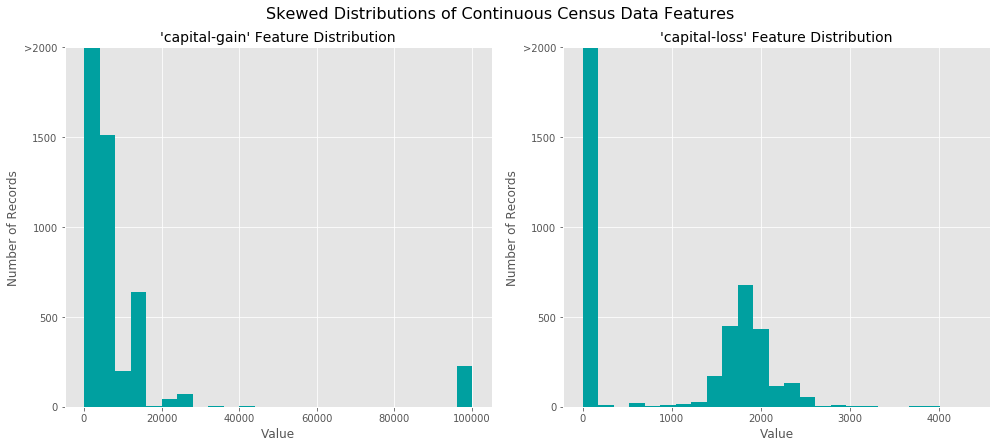

In [9]:
hide_code
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
distribution(data)

For highly-skewed feature distributions such as ***'capital-gain'*** and ***'capital-loss'***, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation, however: the logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the logarithm successfully.

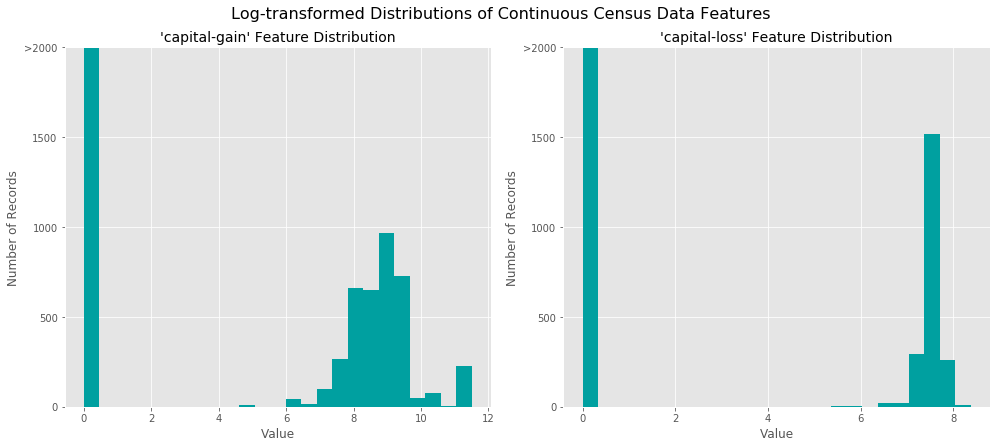

In [10]:
hide_code
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(features_raw, transformed = True)

### 5.2 Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as ***'capital-gain'*** or ***'capital-loss'*** above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning.


In [11]:
hide_code
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 7).T)

,0,1,2,3,4,5,6
age,0.30137,0.452055,0.287671,0.493151,0.150685,0.273973,0.438356
workclass,State-gov,Self-emp-not-inc,Private,Private,Private,Private,Private
education_level,Bachelors,Bachelors,HS-grad,11th,Bachelors,Masters,9th
education-num,0.8,0.8,0.533333,0.4,0.8,0.866667,0.266667
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Married-spouse-absent
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty,Exec-managerial,Other-service
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife,Wife,Not-in-family
race,White,White,White,Black,Black,White,Black
sex,Male,Male,Male,Male,Female,Female,Female
capital-gain,0.0217402,0,0,0,0,0,0


### 5.3 Data Preprocessing

From the table in ***Exploring the Data*** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called ***categorical variables***) be converted. One popular way to convert categorical variables is by using the ***one-hot encoding*** scheme. One-hot encoding creates a ***'dummy'*** variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |
Additionally, as with the non-numeric features, we need to convert the non-numeric target label, ***'income'*** to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [12]:
hide_code
# One-hot encode the 'features_raw' data using pandas.get_dummies()
categorical = ['workclass', 'education_level', 'marital-status', 'occupation', 
              'relationship', 'race', 'sex', 'native-country']
features = pd.DataFrame(features_raw)

for element in categorical:
    features[element] = pd.get_dummies(features_raw[element])

# Encode the 'income_raw' data to numerical values
income = income_raw.replace(['<=50K', '>50K'], [0,1]) 

# Print the number of features after one-hot encoding
encoded = list(features[categorical].columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print (encoded)

8 total features after one-hot encoding.
['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


### 5.4 Shuffle and Split Data
Now all ***categorical variables*** have been converted into numerical features, and all ***numerical features*** have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [70]:
hide_code
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## $\mathfrak {\color{#00A0A0} {6. \ Evaluating \ Model \ Performance}}$
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a ***naive predictor***.

### 6.1 Metrics and the Naive Predictor
***CharityML***, equipped with their research, knows individuals that make more than 50,000 USD are most likely to donate to their charity. Because of this, ***CharityML*** is particularly interested in predicting who makes more than 50,000 USD accurately. It would seem that using ***accuracy*** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that ***does not*** make more than 50,000 USD as someone who does would be detrimental to ***CharityML***, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than 50,000 USD is ***more important*** than the model's ability to ***recall*** those individuals. We can use ***F-beta score*** as a metric that considers both precision and recall:

$$ \color{#00A0A0} {F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall}} $$

In particular, when $\boldsymbol {\beta = 0.5}$, more emphasis is placed on precision. This is called the ***F$_{0.5}$ score*** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most 50,000 USD, and those who make more), it's clear most individuals do not make more than 50,000 USD. This can greatly affect **accuracy**, since we could simply say ***"this person does not make more than 50,000 USD"*** and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the ***naive prediction*** for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than 50,000 USD, ***CharityML*** would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than 50,000 USD, what would that model's accuracy and F-score be on this dataset?*  
### Answer 1

In [14]:
hide_code
warnings.filterwarnings('ignore')
# Calculate accuracy
accuracy = accuracy_score(income, np.array([1]*len(income)))

# Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(income, np.array([1]*len(income)), average='macro', beta=0.5)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.1459]


###  6.2 Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

### Answer 2

### 6.3 Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. The implementation here will be used in the following section.

We will do the following points:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [71]:
hide_code
# Import two metrics from sklearn - fbeta_score and accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average='macro', beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, average='macro', beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### 6.4 Initial Model Evaluation
Next steps are the following:

- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
  
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


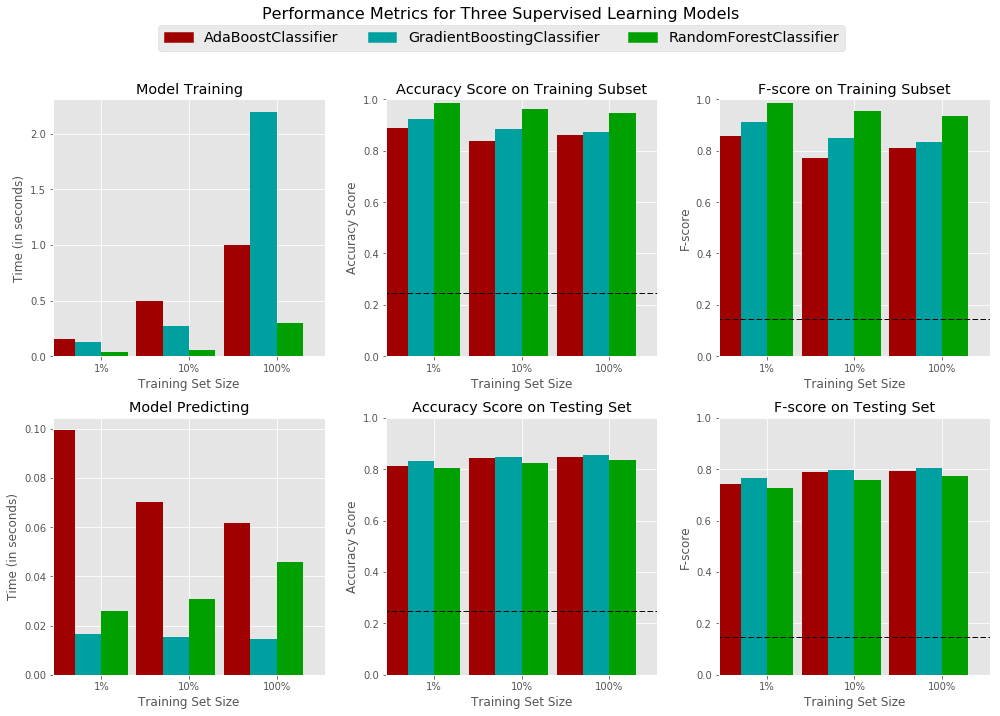

In [72]:
hide_code
# Import the three supervised learning models from sklearn

# Initialize the three models
clf_A = GradientBoostingClassifier(random_state=10)
clf_B = RandomForestClassifier()
clf_C = AdaBoostClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)/100)
samples_10 = int(len(X_train)/10)
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

## $\mathfrak {\color{#00A0A0} {7. \ Improving \ Results}}$
In this final section, we will choose from the three supervised learning models the ***best*** model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to **CharityML** which of the three models you believe to be most appropriate for the task of identifying individuals that make more than 50,000 USD.*  
### Answer 3

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to **CharityML**, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*
### Answer 4

### 7.1 Model Tuning
We will tune the chosen model and use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. 

Our steps:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [73]:
hide_code
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=10)

# Create the parameters list you wish to tune
parameters = {'n_estimators': [100,300,500], 
              'learning_rate':[0.1,0.15,0.2], 
              'max_depth': [2,3,4]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nOptimized Model Parameters\n------")
print (best_clf.get_params())

Unoptimized model
------
Accuracy score on testing data: 0.8541
F-score on testing data: 0.7235

Optimized Model
------
Final accuracy score on the testing data: 0.8573
Final F-score on the testing data: 0.7307

Optimized Model Parameters
------
{'presort': 'auto', 'loss': 'deviance', 'verbose': 0, 'subsample': 1.0, 'max_leaf_nodes': None, 'learning_rate': 0.2, 'warm_start': False, 'min_samples_leaf': 1, 'n_estimators': 300, 'min_samples_split': 2, 'init': None, 'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'random_state': 10, 'min_impurity_split': 1e-07, 'max_features': None, 'max_depth': 2}


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |       0.8541      |   0.8573        |
| F-score        |       0.1459        |       0.7235      |   0.7307        |
### Answer 5


## $\mathfrak {\color{#00A0A0} {8. \ Feature \ Importance}}$
An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than 50,000 USD.

We will choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier, in the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_
### Answer 6

### 8.1 Extracting Feature Importance
We will choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

We will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

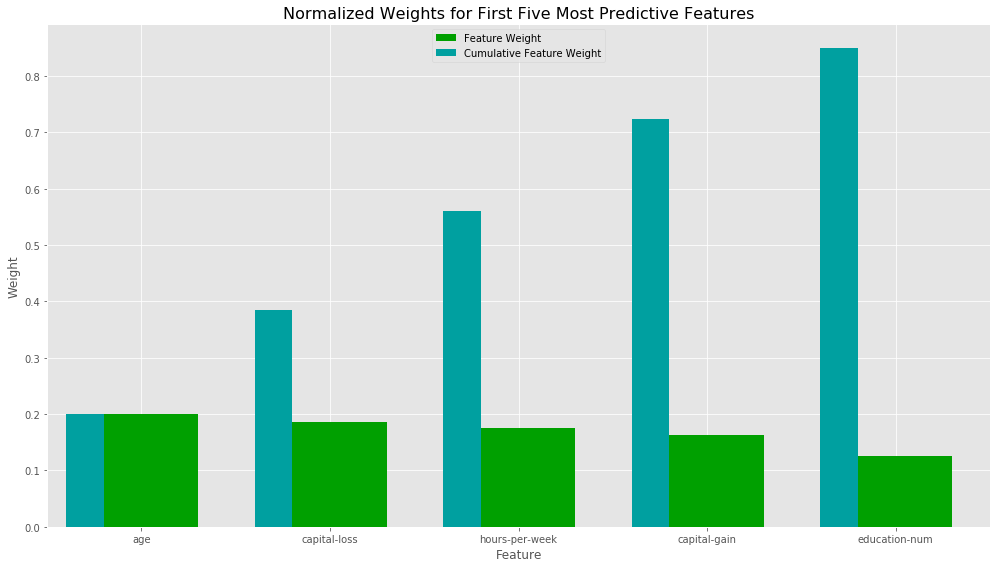

In [74]:
hide_code
# Variant 1
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set 
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, \
                               max_depth=3, random_state=10).fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

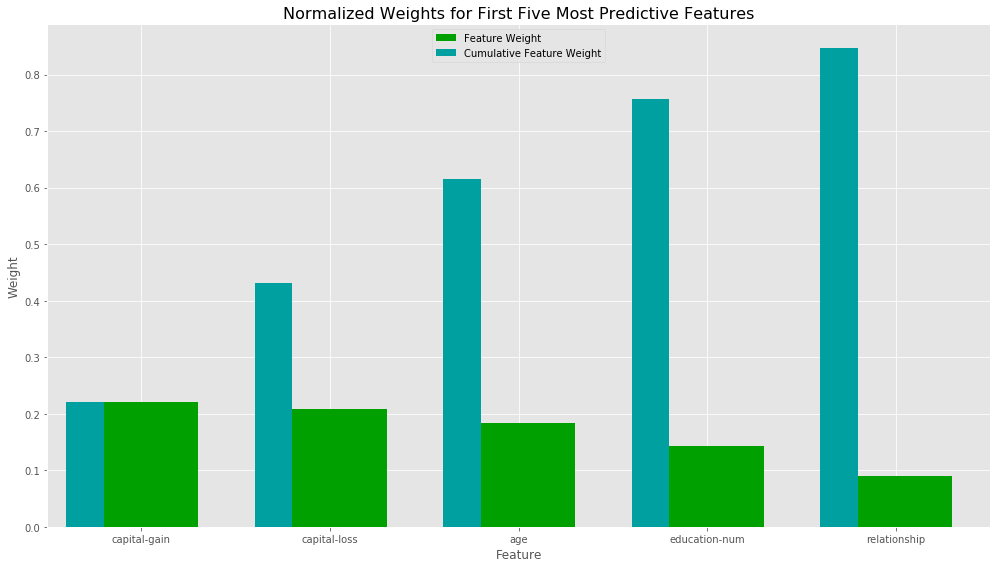

In [75]:
hide_code
# Variant 2
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set 
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, \
                                    max_depth=3, random_state=10).fit(X_train, y_train)

# Extract the feature importances
importances2 = model2.feature_importances_

# Plot
feature_plot(importances2, X_train, y_train)

### Question 7 - Extracting Feature Importance
Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above 50,000 USD.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_
### Answer 7

### 8.2 Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [76]:
hide_code
# Variant 1
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8573
F-score on testing data: 0.7307

Final Model trained on reduced data
------
Accuracy on testing data: 0.8412
F-score on testing data: 0.6949


In [77]:
hide_code
# Variant 2
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced2 = X_train[X_train.columns.values[(np.argsort(importances2)[::-1])[:5]]]
X_test_reduced2 = X_test[X_test.columns.values[(np.argsort(importances2)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced2, y_train)

# Make new predictions
reduced_predictions2 = clf.predict(X_test_reduced2)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions2))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions2, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8573
F-score on testing data: 0.7307

Final Model trained on reduced data
------
Accuracy on testing data: 0.8558
F-score on testing data: 0.7258


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*
### Answer 8

## $\mathfrak {\color{#00A0A0} {9. \ Conclusion}}$